Epoch 0, Cost: 1.581821686856939
Epoch 100, Cost: 1.5664692700155733
Epoch 200, Cost: 1.4445422391173144
Epoch 300, Cost: 1.7037674963102662
Epoch 400, Cost: 0.9101999515899212
Epoch 500, Cost: 0.8184497904316664
Epoch 600, Cost: 0.8352333304446237
Epoch 700, Cost: 0.8542729530055074
Epoch 800, Cost: 1.0508310318687628
Epoch 900, Cost: 0.8261971232182218


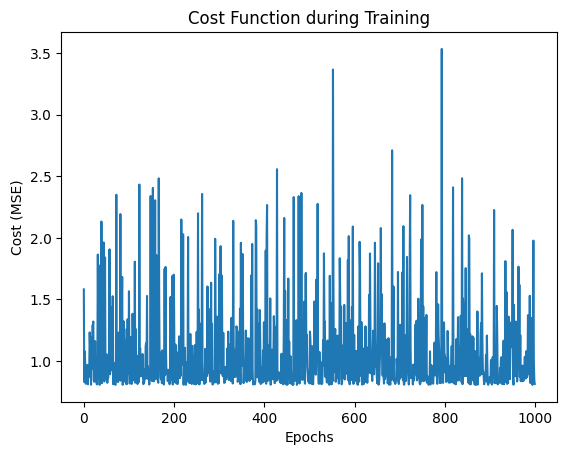

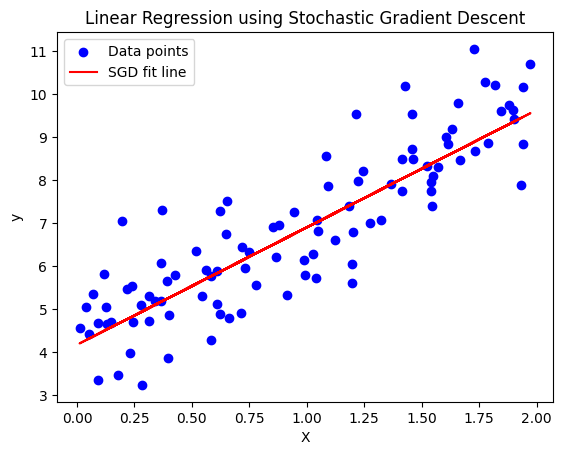

In [8]:
import numpy as np

np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)


def sgd(X, y, learning_rate=0.1, epochs=1000, batch_size=1):
    m = len(X)
    theta = np.random.randn(2, 1)

    X_bias = np.c_[np.ones((m, 1)), X]

    cost_history = []

    for epoch in range(epochs):
        indices = np.random.permutation(m)
        X_shuffled = X_bias[indices]
        y_shuffled = y[indices]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            gradients = 2 / batch_size * \
                X_batch.T.dot(X_batch.dot(theta) - y_batch)
            theta -= learning_rate * gradients

        predictions = X_bias.dot(theta)
        cost = np.mean((predictions - y) ** 2)
        cost_history.append(cost)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Cost: {cost}")

    return theta, cost_history

theta_final, cost_history = sgd(X, y, learning_rate=0.1, epochs=1000, batch_size=1)

import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.xlabel('Epochs')
plt.ylabel('Cost (MSE)')
plt.title('Cost Function during Training')
plt.show()

plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, np.c_[np.ones((X.shape[0], 1)), X].dot(
    theta_final), color='red', label='SGD fit line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression using Stochastic Gradient Descent')
plt.legend()
plt.show()